In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


# Evaluvation of MobileNet-V2

In [2]:

# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(4096, activation='relu', name='fc2')(x)

# Create the modified model
mobile_model = Model(inputs=base_model.input, outputs=x)

# Print model summary
print(mobile_model.summary())




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']      

In [3]:
import os

test_features = {}
directory = r'images'  # Assuming your directory is directly in the working directory

for img_name in tqdm(os.listdir(directory)):
    # Construct the image path
    img_path = os.path.join(directory, img_name)

    # Load the image using your preferred library (replace 'load_img' accordingly)
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to a NumPy array (replace 'img_to_array' accordingly)
    image = img_to_array(image)

    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess the image for VGG (replace 'preprocess_input' accordingly)
    image = preprocess_input(image)

    # Extract features using your model (replace 'model.predict' accordingly)
    feature = mobile_model.predict(image, verbose=0)

    # Extract the image ID from the filename
    image_id = os.path.splitext(img_name)[0]  # Split filename and get the part before extension

    # Store the feature
    test_features[image_id] = feature


  0%|          | 0/729 [00:00<?, ?it/s]

In [4]:
# store features in pickle
pickle.dump(test_features, open('test_mobilenet_features.pkl', 'wb'))

In [5]:
# Assuming the file is in the same directory as your script
with open('captions.txt', 'r') as f:
    # next(f)  # Skip the first line
    captions_doc = f.read()


In [6]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/11936 [00:00<?, ?it/s]

In [7]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [8]:
# preprocess the text
clean(mapping)

In [9]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [10]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [11]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

83

In [12]:
import random

image_ids = list(mapping.keys())

test=image_ids

In [13]:
def filter_train_by_features(features, train):
  """
  Filters the train list to only include items whose keys are present in the features dictionary.

  Args:
      features: A dictionary containing key-value pairs.
      train: A list of items.

  Returns:
      A new list containing only items from train whose keys are present in features.
  """
  return [item for item in train if item in features]

# # Example usage
# features = {"a": 1, "b": 2, "c": 3}
# train = ["a", "x", "b", "y", "c"]

filtered_test = filter_train_by_features(test_features, test)
print(filtered_test)

['0', '4', '5', '6', '7', '11', '15', '16', '18', '19', '23', '25', '30', '54', '64', '65', '71', '72', '74', '80', '83', '90', '94', '98', '100', '109', '113', '114', '123', '125', '127', '128', '131', '134', '140', '142', '143', '147', '148', '149', '156', '160', '161', '168', '174', '179', '183', '193', '196', '197', '198', '199', '207', '209', '210', '213', '214', '218', '223', '227', '236', '238', '239', '241', '243', '246', '247', '257', '259', '262', '265', '273', '278', '282', '284', '285', '297', '298', '300', '301', '303', '305', '310', '315', '317', '318', '320', '323', '327', '329', '341', '343', '344', '346', '348', '353', '354', '355', '361', '363', '364', '369', '370', '373', '374', '375', '380', '381', '382', '386', '388', '389', '392', '398', '399', '400', '402', '407', '411', '413', '420', '421', '423', '424', '425', '426', '429', '434', '436', '438', '446', '451', '455', '459', '466', '481', '484', '487', '492', '497', '500', '504', '507', '512', '513', '514', '515',

In [14]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [29]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('mobilenet_model.h5')
# Now you can use this model for predictions or any other purposes


In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [65]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(filtered_test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, test_features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(0.1, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/716 [00:00<?, ?it/s]

BLEU-1: 0.632833
BLEU-2: 0.500557


In [33]:
str_predicted = [' '.join(inner_list) for inner_list in predicted]

str_actual = [
    ' '.join(inner_list)  # Join words in each inner list
    for outer_list in actual  # Iterate through outer lists
    for inner_list in outer_list  # Iterate through inner lists containing captions
]


In [68]:
from rouge_score import rouge_scorer

sum=0

n=0
for j in range(716):
  rouge=[]
  for i in range(5*n,5*n+5):
    scorer=rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    scores = scorer.score(str_predicted[j], str_actual[i])
    rouge.append(scores['rouge1'].precision)
    # print(i)
  n+=1
  sum+=max(rouge)

print("Rouge - 1 : ", sum/716)

Rouge - 1 :  0.5807237819481117


# Evaluvation of VGG-16

In [67]:
# load vgg16 model
model = VGG16()
# restructure the model
vgg_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 532s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [69]:
import os

vgg_test_features = {}
directory = r'images'  # Assuming your directory is directly in the working directory

for img_name in tqdm(os.listdir(directory)):
    # Construct the image path
    img_path = os.path.join(directory, img_name)

    # Load the image using your preferred library (replace 'load_img' accordingly)
    image = load_img(img_path, target_size=(224, 224))

    # Convert image pixels to a NumPy array (replace 'img_to_array' accordingly)
    image = img_to_array(image)

    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocess the image for VGG (replace 'preprocess_input' accordingly)
    image = preprocess_input(image)

    # Extract features using your model (replace 'model.predict' accordingly)
    feature = vgg_model.predict(image, verbose=0)

    # Extract the image ID from the filename
    image_id = os.path.splitext(img_name)[0]  # Split filename and get the part before extension

    # Store the feature
    vgg_test_features[image_id] = feature


  0%|          | 0/729 [00:00<?, ?it/s]

In [70]:
def filter_train_by_features(features, train):
  """
  Filters the train list to only include items whose keys are present in the features dictionary.

  Args:
      features: A dictionary containing key-value pairs.
      train: A list of items.

  Returns:
      A new list containing only items from train whose keys are present in features.
  """
  return [item for item in train if item in features]

# # Example usage
# features = {"a": 1, "b": 2, "c": 3}
# train = ["a", "x", "b", "y", "c"]

vgg_filtered_test = filter_train_by_features(vgg_test_features, test)
print(vgg_filtered_test)

['0', '4', '5', '6', '7', '11', '15', '16', '18', '19', '23', '25', '30', '54', '64', '65', '71', '72', '74', '80', '83', '90', '94', '98', '100', '109', '113', '114', '123', '125', '127', '128', '131', '134', '140', '142', '143', '147', '148', '149', '156', '160', '161', '168', '174', '179', '183', '193', '196', '197', '198', '199', '207', '209', '210', '213', '214', '218', '223', '227', '236', '238', '239', '241', '243', '246', '247', '257', '259', '262', '265', '273', '278', '282', '284', '285', '297', '298', '300', '301', '303', '305', '310', '315', '317', '318', '320', '323', '327', '329', '341', '343', '344', '346', '348', '353', '354', '355', '361', '363', '364', '369', '370', '373', '374', '375', '380', '381', '382', '386', '388', '389', '392', '398', '399', '400', '402', '407', '411', '413', '420', '421', '423', '424', '425', '426', '429', '434', '436', '438', '446', '451', '455', '459', '466', '481', '484', '487', '492', '497', '500', '504', '507', '512', '513', '514', '515',

In [71]:
from tensorflow.keras.models import load_model

# Load the saved model
vgg_model = load_model('VGG_model.h5')
# Now you can use this model for predictions or any other purposes


In [75]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(vgg_filtered_test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(vgg_model, vgg_test_features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/716 [00:00<?, ?it/s]

BLEU-1: 0.701840
BLEU-2: 0.556033


In [76]:
str_predicted = [' '.join(inner_list) for inner_list in predicted]

str_actual = [
    ' '.join(inner_list)  # Join words in each inner list
    for outer_list in actual  # Iterate through outer lists
    for inner_list in outer_list  # Iterate through inner lists containing captions
]


In [77]:
from rouge_score import rouge_scorer

sum=0

n=0
for j in range(716):
  rouge=[]
  for i in range(5*n,5*n+5):
    scorer=rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
    scores = scorer.score(str_predicted[j], str_actual[i])
    rouge.append(scores['rouge1'].precision)
    # print(i)
  n+=1
  sum+=max(rouge)

print("Rouge - 1 : ", sum/716)

Rouge - 1 :  0.6581966708121102


In [78]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_path):
    # Load the image
    image = Image.open(image_path)

    # Predict the caption
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
    # Predict the caption
    y_pred = predict_caption(vgg_model, vgg_test_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    
    # Display the image
    plt.imshow(image)


---------------------Actual---------------------
startseq abstract elements suggesting surge in aggression. endseq
startseq the distant uproar of frustrated crowd growing more pronounced. endseq
startseq an influx of disgruntled individuals adds to the escalating tension. endseq
startseq the vivid conclusion: an unsettling image of an office environment charged with hostility as frustrated crowd pours in. endseq
startseq moments of heightened workplace tension in fragmented scenes. endseq
--------------------Predicted--------------------
startseq the growing cacophony as crowd expresses mounting frustration endseq


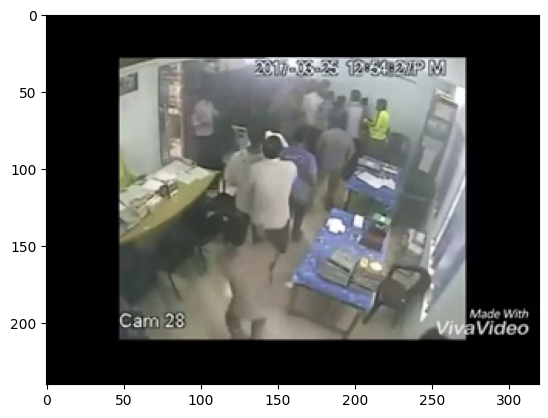

In [83]:
generate_caption("100.jpg")


---------------------Actual---------------------
startseq disturbing scene unfolds depicting an act of extreme violence and aggression. endseq
startseq the brutality intensifies as person wields rod adding to the victim's suffering. endseq
startseq the merciless beating continues with the victim being forcibly moved around unable to escape. endseq
startseq shockingly no one intervenes or attempts to halt the group's relentless assault. endseq
startseq in horrifying display of cruelty the helpless man endures blows to every part of his body inflicted by fists legs and brutal rod. endseq
--------------------Predicted--------------------
startseq the brutality intensifies depicting the victim is thrown around helpless against the relentless onslaught endseq


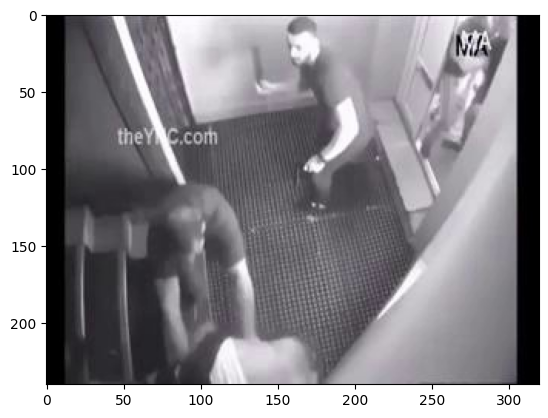

In [84]:
generate_caption("512.jpg")

---------------------Actual---------------------
startseq as tension simmers two individual grips menacing rod preparing for confrontation. endseq
startseq the fallen figure remains stil. endseq
startseq solitary observer slips away. endseq
startseq abrupt arrival of newcomer. endseq
startseq night falls and darkness envelops the surroundings. endseq
--------------------Predicted--------------------
startseq the fallen figure lies motionless on the ground endseq


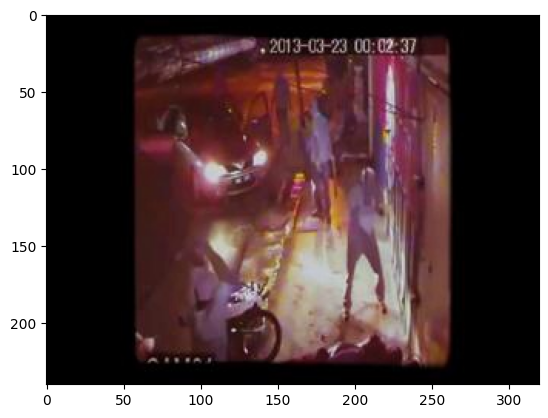

In [85]:
generate_caption("1460.jpg")

---------------------Actual---------------------
startseq the individual in white attire is observed hitting someone else. endseq
startseq the room is engulfed in peaceful atmosphere. endseq
startseq the individual facing aggression is carrying bag. endseq
startseq the individual in the blue attire is receiving punch. endseq
startseq the male in the white attire is delivering the punch. endseq
--------------------Predicted--------------------
startseq the person being subjected to violence has bag in him endseq


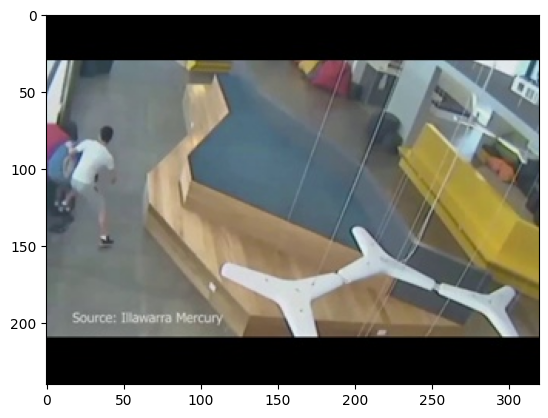

In [87]:
generate_caption("2154.jpg")